# Step 1: Select GPU from Edit
# Step 2: Cloning and Building Darknet

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

In [ ]:
# make darknet (build)
!make

# Step 3: Download pretrained YOLOv3 weights
:YOLOv3 has been trained already on the coco dataset which has 80 classes that it can predict. We will grab these pretrained weights so that we can run YOLOv3 on these pretrained classes and get detections.

In [ ]:
# get yolov3 pretrained coco dataset weights
!wget https://pjreddie.com/media/files/yolov3.weights

In [ ]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

# Step 4: Connect to google drive

In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

In [ ]:
%cd darknet

# Step 5: Moving Your Custom Dataset Into Your Cloud VM

In [ ]:
# this is where my zip is stored (I created a yolov3 folder where I will get my required files from)
!ls /mydrive/yolov3

In [ ]:
# copy the .zip file into the root directory of cloud VM
!cp /mydrive/yolov3/obj.zip ../

In [ ]:
## to remove a folder
# !rm -r ../data

In [ ]:
# unzip the zip file and its contents should now be in /darknet/data/obj
!unzip ../obj.zip -d /content/data/

In [ ]:
!mv /content/data/obj /content/darknet/data

# Step 6: Configuring Files for Training
This step involves properly configuring your custom .cfg file, obj.data, obj.names and train.txt file.

## i) Cfg File
Copy over the yolov3.cfg to edit by running the cell below.

In [ ]:
# download cfg to google drive and change its name
# !cp cfg/yolov3.cfg /mydrive/yolov3/yolov3_custom.cfg

In [ ]:
# to download to local machine (change its name to yolov3_custom.cfg once you download)
# download('cfg/yolov3.cfg')

In [ ]:
# upload the custom .cfg back to cloud VM from Google Drive
!cp /mydrive/yolov3/yolov3_custom.cfg ./cfg

## ii) obj.names and obj.data 
Create a new file within a code or text editor called **obj.names** and you will make this file exactly the same as your classes.txt in the dataset generation step.

In [ ]:
# upload the obj.names and obj.data files to cloud VM from Google Drive
!cp /mydrive/yolov3/obj.names ./data
!cp /mydrive/yolov3/obj.data  ./data

# upload the obj.names and obj.data files to cloud VM from local machine (uncomment to use)
#%cd data
#upload()
#%cd .. 

In [ ]:
!pwd

## iii) Generating train.txt
The last configuration file needed before we can begin to train our custom detector is the train.txt file which hold the relative paths to all our training images.

In [ ]:
# upload the generate_train.py script to cloud VM from Google Drive
!cp /mydrive/yolov3/generate_train.py ./

# upload the generate_train.py script to cloud VM from local machine (uncomment to use)
#upload()

Now we simply run the python script to do all the work for us.

In [ ]:
!python ./generate_train.py

In [ ]:
# verify train.txt can be seen in our darknet/data folder
!ls data/

If everything went as planned double click on **train.txt** on the left side File Explorer and it should look like this.
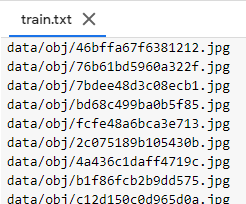

It will contain one line for each training image path.

# Step 7: Download pre-trained weights for the convolutional layers.
This step downloads the weights for the convolutional layers of the YOLOv3 network. By using these weights it helps your custom object detector to be way more accurate and not have to train as long. You don't have to use these weights but trust me it will help your modle converge and be accurate way faster. USE IT!

In [ ]:
# upload pretrained convolutional layer weights
!wget http://pjreddie.com/media/files/darknet53.conv.74

# Step 8: Train Your Custom Object Detector!

!./darknet detector train <path to obj.data> <path to custom config> darknet53.conv.74 -dont_show
```

In [ ]:
# train your custom detector
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg darknet53.conv.74 -dont_show

You can observe a chart of how your model did throughout the training process by running the below command. It shows a chart of your average loss vs. iterations. For your model to be 'accurate' you would aim for a loss under 2.

In [ ]:
imShow('chart.png')

In [ ]:
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg /mydrive/yolov3/backup/yolov3_custom_last.weights -dont_show

# Step 9: Run Your Custom Object Detector!!!
You have done it! You now have a custom object detector to make your very own detections. Time to test it out and have some fun!

In [ ]:
# need to set our custom cfg to test mode 
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov3_custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov3_custom.cfg
%cd ..


In [ ]:
# !./darknet detector test data/obj.data cfg/yolov3_custom.cfg /mydrive/yolov3/backup/yolov3_custom_last_3.weights /content/3.png -tresh .4
# imShow('predictions.jpg')

In [ ]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /mydrive/yolov3/backup/yolov3_custom_last_0.weights /content/96.png -thresh 0.4
imShow('predictions.jpg')